# Imports and other setup

In [2]:
# data processing
import pandas as pd
import numpy as np
from numpy import genfromtxt

# graphs / figures
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import networkx as nx

# sklearn / models
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, FeatureAgglomeration
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# nltk
import nltk
from nltk.corpus import stopwords

# others
import os
import sys
sys.path.append('../')
from embedding_functions_hugo.embedding_functions import *
from tqdm import tqdm
from bs4 import BeautifulSoup
import re
from happytransformer import HappyTextClassification
import praw

def shorten_and_clean_dataset (comment_csv, comment_column : str, desired_comment_length : int):
    dataframe = pd.read_csv(comment_csv)
    dataframe['cleaned_text'] = prep_pipeline(dataframe, comment_column)
    dataframe['short'] = shorten_sens(dataframe['cleaned_text'], desired_comment_length)
    return dataframe

2023-04-24 11:41:56.829890: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Processing

### Function for getting post_title, post_author, post_id, and the embedded title texts

In [3]:
def do_post_titles(df):
    texts, authors, post_ids = [], [], []
    title_author_set = set(zip(df['post_title'], df['post_author'], df['post_id']))

    for text, author, post_id in  title_author_set:
        texts.append(text)
        authors.append(author)
        post_ids.append(post_id)
    
    title_embeddings = embed_comments(texts)
    return pd.DataFrame(data=[post_ids, authors, texts, title_embeddings]).T.rename(columns={0 : 'post_id', 1: 'post_author', 2: 'post_title', 3: 'embeddings'})

### filtering out unwanted users

In [4]:
def remove_nan(df):
    '''Takes dataframe as input, removed rows where username is nan'''

    for idx, row in df.iterrows():
        usr1 = row[2]
        usr2 = row[4]

        if type(usr1) != str or type(usr2) != str:
            df.drop(idx, axis=0, inplace=True)
    
    return df

### Getting final dataframe that we can use

In [5]:
def shorten_comment_text(df):
    '''Takes dataframe as input, shortens comment text, creates short_text column and removes comment_text column'''
    
    # getting all commenters that have also made a post
    shortened_df = df.query('comment_author in post_author').copy()

    # cleaning their comments and saving to new column
    clean_text = prep_pipeline(shortened_df, 'comment_text', loud=False)
    shortened_df['short_text'] = shorten_sens(clean_text, 50)
    shortened_df.drop('comment_text', axis=1, inplace=True)

    return shortened_df

In [6]:
def get_embed_pairs(df):
   '''Takes dataframe as input, combines all user title texts into one
      Returns embed_pairs'''
    
   # for each poster, appending all of their post text into one long string
   embed_pairs = {}
   for text, author in zip(df['post_title'], df['post_author']):
      if author not in embed_pairs.keys():
         embed_pairs[author] = text
      else:
         embed_pairs[author] += ' '+text

   return embed_pairs

def get_title_embeds(embed_pairs):
   '''Takes embed_pairs as input. Embeds the post titles and returns an array of them.'''

   # embedding all post titles and reducing them to 1 dimension
   embeds = dict(zip(embed_pairs.keys(), embed_comments(list(embed_pairs.values()))))
   embeds = reduce_to_one_dimension_kmeans(embeds)[-1]

   return embeds

In [7]:
def reduce_to_poster_commentors(df):
    '''given a df, reduces rows recursively until all commentors and posters are both commentors and posters'''

    # might be faster with doing query multiple times until no changes

    done = False
    initialized = False
    while done != True:

        comment_authors = list(df['comment_author'])
        post_authors = list(df['post_author'])

        if initialized == False:
            before = 0
            initialized = True
        else:
            before = len(users_to_include)

        users_to_include = set()

        after = 0

        for idx, row in df.iterrows():

            commentor = row[2]

            if commentor in post_authors:
                if commentor not in users_to_include:
                    # print(commentor)
                    users_to_include.add(commentor)
                    after += 1
            
            else:
                df.drop(idx, inplace=True)

        diff = after - before
        
        if diff == 0:
            print(f'before = {before} and after = {after}, so diff = {diff}, done!')
            done = True
        else:
            print(f'before = {before} and after = {after}, so diff = {diff}, relooping...')

    return df

# Creating Network

In [8]:
def create_network(df):
    '''Takes dataframe as input, creates a directed networkx network and returns it'''

    # Initializing text classification model
    model = HappyTextClassification(model_type='DISTILBERT', model_name='distilbert-base-uncased-finetuned-sst-2-english', num_labels=2)

    # initializing networkx directed graph
    G = nx.DiGraph()

    # # ensuring only looking at users that have both commented and posted
    # df = df.query('comment_author in post_author')

    print('doing embed_pairs')

    # combining users title texts into one
    embed_pairs = get_embed_pairs(df)

    print(len(embed_pairs))

    print('doing embeds')

    # embedding those combined title texts
    embeds = get_title_embeds(embed_pairs)

    print(len(embeds))

    # adding each post author as a node to network, with their 1 dimensional title embeddings as an attribute (named polarity)
    print('\n===== adding nodes ======\n')
    for i, j in zip(embed_pairs.keys(), embeds):
        print(f'added {i} with polarity {int(j)}')
        G.add_node(i, polarity = int(j))

    # getting list of user pairs for comments left on posts
    pairings = list(zip(df['comment_author'], df['post_author']))
    print(len(pairings))

    print('doing polarities')

    # classifying sentiments of comment texts and saving them in list "polarities"
    polarities = []
    signs = []
    for comment in df['short_text']:
        classification = model.classify_text(comment)
        polarities.append(classification.score)

        if classification.label == 'POSITIVE':
            signs.append(1)
        elif classification.label == 'NEGATIVE':
            signs.append(-1)
    
    print(len(polarities))

    print('\n===== adding edges =====\n')
    # adding edges to graph, where each edge is a comment left by user a to user b, and its attribute is the sentiment of the comment
    for pair, polarity, sign in zip(pairings, polarities, signs):
        if pair[0] != pair[1]: # avoiding self edge connections
            # need positive or negative for sign
            print(f'adding edge from {pair[0]} to {pair[1]} with sentiment {polarity} and label {sign}')
            G.add_edge(u_of_edge=pair[0], v_of_edge=pair[1], sentiment=polarity, sign=sign)

    # drawing network
    nx.draw(G)

    return G

In [9]:
def full_pipeline(df):
    '''does everything and returns network'''
    # doing pre-network stuff
    print('removing nan...')
    df = remove_nan(df)
    print('reducing to poster commentors...')
    df = reduce_to_poster_commentors(df)
    print('shortening comment text...')
    df = shorten_comment_text(df)

    print('creating network...')
    # creating and drawing network
    G = create_network(df)

    return G

## Creating, initially inspecting and saving subreddits

Example filepath: '../data/19march/graphs/politics_network.gexf'

Make sure the filepath exists before running (manually create them) as otherwise it will take ~12 mins to run and end up giving an error

### r/politics - takes ~11 mins with 19march politics

In [10]:
# # grabbing scraped df
# df_politics = pd.read_csv('../data/23march_chur/scrapes/politics.csv')

# G_politics = full_pipeline(df_politics)

# # saving network
# nx.write_gexf(G_politics, '../data/23march_chur/graphs/politics_nan.gexf')

### r/music - takes ~8 mins with 2april music

In [11]:
# # grabbing scraped df
# df_music = pd.read_csv('../data/2april/scrapes/2apr_2Music.csv')

# G_music = full_pipeline(df_music)

# # saving network
# nx.write_gexf(G_music, '../data/2april/graphs/music.gexf')

### r/antiwork

In [12]:
# # grabbing scraped df
# df_antiwork = pd.read_csv('../data/17april/scrapes/antiwork.csv')

# G_antiwork = full_pipeline(df_antiwork)

# # saving network
# nx.write_gexf(G_antiwork, '../data/17april/graphs/antiwork.gexf')

### r/gaming - takes ~20 mins with 4april gaming

In [13]:
# # grabbing scraped df
# df_gaming = pd.read_csv('../data/4april/scrapes/gaming.csv')

# G_gaming = full_pipeline(df_gaming)

# # saving network
# nx.write_gexf(G_gaming, '../data/4april/graphs/gaming.gexf')

### r/EscapefromTarkov

In [14]:
# # grabbing scraped df
# df_tarkov = pd.read_csv('../data/19march/scrapes/EscapefromTarkov.csv')

# # doing pre-network stuff
# df_tarkov_shortened = shorten_comment_text(df_tarkov)

# # creating and drawing network
# G_tarkov = create_network(df_tarkov_shortened)

# # saving network
# nx.write_gexf(G_tarkov, '../data/19march/graphs/tarkov_network_nan.gexf')

### r/HuntShowdown

In [15]:
# # grabbing scraped df
# df_HuntShowdown = pd.read_csv('../data/19march/scrapes/HuntShowdown.csv')

# # doing pre-network stuff
# df_HuntShowdown_shortened = shorten_comment_text(df_HuntShowdown)

# # creating and drawing network
# G_HuntShowdown = create_network(df_HuntShowdown_shortened)

# # saving network
# nx.write_gexf(G_HuntShowdown, '../data/19march/graphs/HuntShowdown_network_nan.gexf')

removing nan...
reducing to poster commentors...
before = 0 and after = 23, so diff = 23, relooping...
before = 23 and after = 23, so diff = 0, done!
shortening comment text...
creating network...


04/24/2023 11:42:06 - INFO - happytransformer.happy_transformer -   Using model: cpu


doing embed_pairs
63
doing embeds


[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


63

===== adding nodes ======

added tachibanakanade with polarity -4
added Zhang_Chunqiao with polarity -7
added Far_Permission_8659 with polarity -3
added Better-Raspberry-901 with polarity 0
added pashotboshot with polarity -7
added yellouxsims with polarity -3
added GloriousBand with polarity 0
added GenosseMarx3 with polarity -4
added AdrianCuba with polarity -4
added Thankkratom with polarity 0
added goaway2k18 with polarity 2
added Then-Ganache8054 with polarity -1
added CZiemba with polarity 0
added Deep-Site-8326 with polarity -3
added NinoFiore95 with polarity 6
added yhl3052 with polarity 0
added ChooseOn with polarity -1
added mushroomisst with polarity -7
added Salt_Ad_4875 with polarity 0
added whentheseagullscry with polarity -2
added Otherwise_Airport325 with polarity 1
added -thr0wawayawaw0rht- with polarity 0
added bttrfly99 with polarity 2
added Prior-Jackfruit-5899 with polarity -2
added ttxd_88 with polarity -1
added variegatedcroton1 with polarity 1
added HappyHan

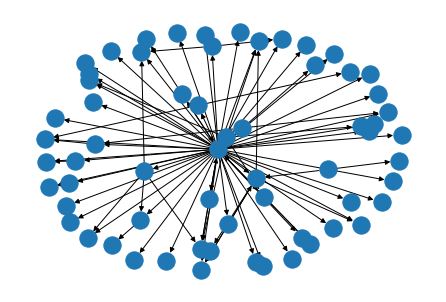

In [16]:
# grabbing scraped df
df_antiwork = pd.read_csv('../data/date_folders/april_24/scrapes/communism.csv')

G_antiwork = full_pipeline(df_antiwork)

# saving network
nx.write_gexf(G_antiwork, '../data/date_folders/april_24/graphs/communism.gexf')

removing nan...
reducing to poster commentors...
before = 0 and after = 82, so diff = 82, relooping...
before = 82 and after = 49, so diff = -33, relooping...
before = 49 and after = 40, so diff = -9, relooping...
before = 40 and after = 35, so diff = -5, relooping...
before = 35 and after = 26, so diff = -9, relooping...
before = 26 and after = 21, so diff = -5, relooping...
before = 21 and after = 19, so diff = -2, relooping...
before = 19 and after = 19, so diff = 0, done!
shortening comment text...
creating network...


04/24/2023 11:42:17 - INFO - happytransformer.happy_transformer -   Using model: cpu


doing embed_pairs
22
doing embeds


[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


22

===== adding nodes ======

added HeywoodJaBlowMe123 with polarity 4
added Binary245 with polarity 0
added Crazen14 with polarity 6
added AdRemarkable2704 with polarity 3
added Cheese-Gorilla-Fart- with polarity 0
added kngfbng with polarity 8
added SolidSnacked with polarity -3
added Jadams0108 with polarity -4
added ZENyBoi2010 with polarity -1
added rugershooter323 with polarity 0
added Far_Marionberry_9478 with polarity 0
added Harvvester with polarity -2
added Buck_de_Luck with polarity -6
added No-Operation3712 with polarity -5
added photosynthescythe with polarity 4
added HEALPony with polarity 3
added Man-of-the-sea- with polarity -6
added starosexx with polarity 6
added Dr-Chuckyy with polarity -6
added Santa_Claus77 with polarity 1
added Castironspoon with polarity -7
added alicemudgarden5 with polarity 5
29
doing polarities
29

===== adding edges =====

adding edge from Far_Marionberry_9478 to Binary245 with sentiment 0.9974945783615112 and label -1
adding edge from Man-o

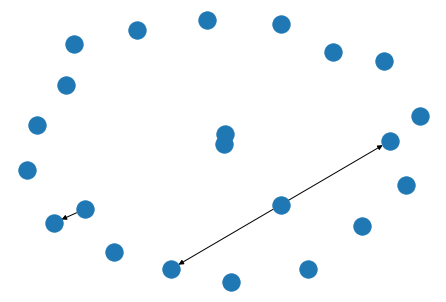

In [17]:
# grabbing scraped df
df_antiwork = pd.read_csv('../data/date_folders/april_18/scrapes/CallOfDuty.csv')

G_antiwork = full_pipeline(df_antiwork)

# saving network
nx.write_gexf(G_antiwork, '../data/date_folders/april_18/graphs/CallOfDuty.gexf')

removing nan...
reducing to poster commentors...
before = 0 and after = 432, so diff = 432, relooping...
before = 432 and after = 377, so diff = -55, relooping...
before = 377 and after = 364, so diff = -13, relooping...
before = 364 and after = 364, so diff = 0, done!
shortening comment text...
creating network...


04/24/2023 11:44:19 - INFO - happytransformer.happy_transformer -   Using model: cpu


doing embed_pairs
532
doing embeds


[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


532

===== adding nodes ======

added Caesaaar with polarity -3
added eriskendaj with polarity 2
added BigXBenz with polarity -8
added Darfoz11 with polarity 1
added NikoB44 with polarity 8
added DomagojDoc with polarity 0
added MunyaRa with polarity 0
added Quacky-Duck with polarity -4
added OVO_Papi with polarity -1
added Juil8991MC with polarity 0
added blowfish_cro with polarity 3
added EraticConqueror with polarity 2
added Imhere4urdownvotes with polarity -4
added Sleepy10105s with polarity 2
added DarkandBrisingr with polarity -4
added InternalCondition419 with polarity -1
added akinator2002 with polarity 0
added guhardrock with polarity 0
added Bumble13 with polarity 0
added PrinceMaher7 with polarity -4
added McVanQu with polarity -2
added ChrisDoesCowTipping with polarity 1
added GeorgeCuz with polarity 0
added JaySeaGaming with polarity -2
added rww07 with polarity -1
added cguinnesstout with polarity 2
added robbery0 with polarity -5
added aautoauto with polarity 0
added R1d

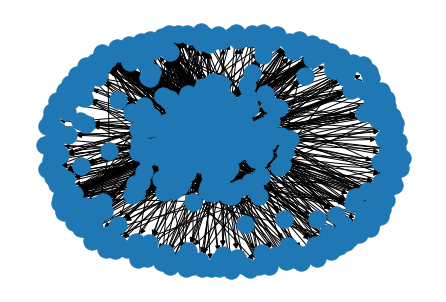

In [18]:
# grabbing scraped df
df_antiwork = pd.read_csv('../data/date_folders/april_18/scrapes/FIFA.csv')

G_antiwork = full_pipeline(df_antiwork)

# saving network
nx.write_gexf(G_antiwork, '../data/date_folders/april_18/graphs/FIFA.gexf')